In [1]:
import numpy as np
import torch
#导入pytorch内置的mnist数据
from torchvision.datasets import mnist
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [2]:
#定义超参
train_batch_size=64
test_batch_size=128
learning_rate=0.01
num_epoches=20
lr=0.01
momentum=0.5

In [3]:
#下载数据并对数据预处理
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])
train_dataset=mnist.MNIST('./data',train=True,transform=transform,download=True)
test_dataset=mnist.MNIST('./data',train=False,transform=transform)
train_loader=DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=test_batch_size,shuffle=False)

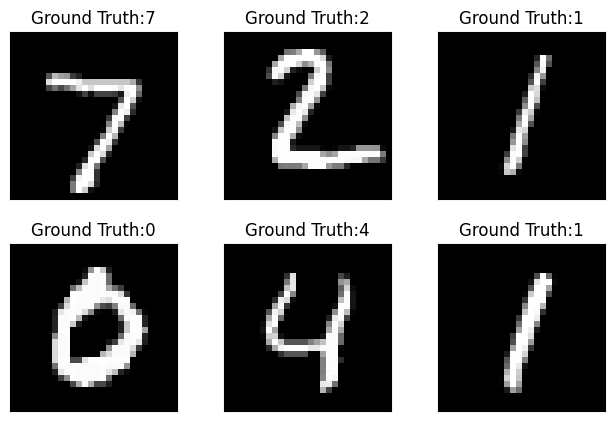

In [5]:
import matplotlib.pyplot as plt
examples=enumerate(test_loader)
batch_idx,(example_data,example_targets)=next(examples)
fig=plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Ground Truth:{}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [6]:
#构建网络
class Net(nn.Module):
    def __init__(self,in_dim,n_hidden_1,n_hidden_2,out_dim):
        super(Net,self).__init__()
        self.layer1=nn.Sequential(nn.Linear(in_dim,n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2=nn.Sequential(nn.Linear(n_hidden_1,n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3=nn.Sequential(nn.Linear(n_hidden_2,out_dim))
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x =self.layer3(x)
        return x


In [7]:
#实例化网络
#检测是否可用gpu，不可用则调用cpu
device=torch.device("cuda:0" if torch.cuda.is_available()else "cpu" )
#实例化网络
model=Net(28*28,300,100,10)
model.to(device)
#定义损失函数和优化器
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=lr,momentum=momentum)

In [8]:
#训练模型
losses=[]
acces=[]
eval_losses=[]
eval_acces=[]
for epoch in range(num_epoches):
    train_loss=0
    train_acc=0
    model.train()
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
    for img , label in train_loader:
        img=img.to(device)
        label=label.to(device)
        img=img.view(img.size(0),-1)
        out=model(img)
        loss=criterion(out,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        _,pred=out.max(1)
        num_correct=(pred==label).sum().item()
        acc=num_correct/img.shape[0]
        train_acc+=acc

    losses.append(train_loss/len(train_loader))
    acces.append(train_acc/len(train_loader))
    eval_loss=0
    eval_acc=0
    model.eval()
    for img,label in test_loader:
        img=img.to(device)
        label=label.to(device)
        img=img.view(img.size(0),-1)
        out=model(img)
        loss=criterion(out,label)
        eval_loss+=loss.item()
        _,pred=out.max(1)
        num_correct=(pred==label).sum().item()
        acc=num_correct/img.shape[0]
        eval_acc+=acc
    eval_losses.append(eval_loss/len(test_loader))
    eval_acces.append(eval_acc/len(test_loader))
    print('epoch:{},Train Loss:{:.4f},Train Acc:{:.4f}.Test Loss:{:.4f},Test Acc:{:.4f}'.format(epoch,train_loss/len(train_loader),train_acc/len(train_loader),eval_loss/len(test_loader),eval_acc/len(test_loader)))

epoch:0,Train Loss:1.0407,Train Acc:0.7777.Test Loss:0.5508,Test Acc:0.9019
epoch:1,Train Loss:0.4817,Train Acc:0.9003.Test Loss:0.3524,Test Acc:0.9258
epoch:2,Train Loss:0.3472,Train Acc:0.9206.Test Loss:0.2706,Test Acc:0.9383
epoch:3,Train Loss:0.2812,Train Acc:0.9326.Test Loss:0.2250,Test Acc:0.9472
epoch:4,Train Loss:0.2386,Train Acc:0.9409.Test Loss:0.1955,Test Acc:0.9511
epoch:5,Train Loss:0.2192,Train Acc:0.9467.Test Loss:0.1950,Test Acc:0.9509
epoch:6,Train Loss:0.2161,Train Acc:0.9470.Test Loss:0.1908,Test Acc:0.9531
epoch:7,Train Loss:0.2132,Train Acc:0.9472.Test Loss:0.1885,Test Acc:0.9528
epoch:8,Train Loss:0.2116,Train Acc:0.9477.Test Loss:0.1863,Test Acc:0.9527
epoch:9,Train Loss:0.2089,Train Acc:0.9489.Test Loss:0.1829,Test Acc:0.9541
epoch:10,Train Loss:0.2063,Train Acc:0.9492.Test Loss:0.1832,Test Acc:0.9534
epoch:11,Train Loss:0.2069,Train Acc:0.9497.Test Loss:0.1839,Test Acc:0.9535
epoch:12,Train Loss:0.2075,Train Acc:0.9485.Test Loss:0.1818,Test Acc:0.9546
epoch:13,

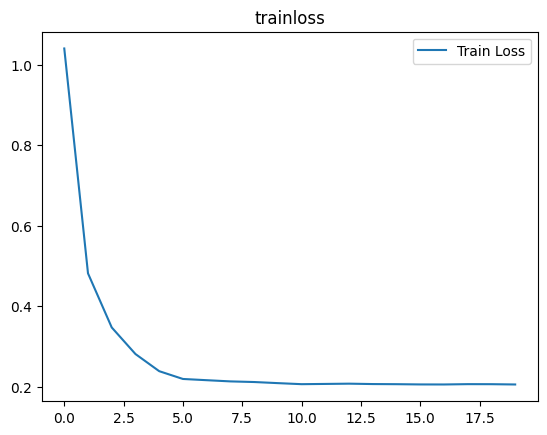

In [10]:
plt.title('trainloss')
plt.plot(np.arange(len(losses)),losses)
plt.legend(['Train Loss'],loc='upper right')